## Neural Network Notebook ##

A first draft of the neural network that will be used for the ECG classification project is described in this notebook.

### Initialization ###

We will train our model  with the help of the TensorFlow framework. If you had not installed TensorFlow yet, you can do it easily with the command pip install --upgrade tensorflow.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

### Part 1 : importing the data ###

Found 6 files belonging to 6 classes.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 6 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

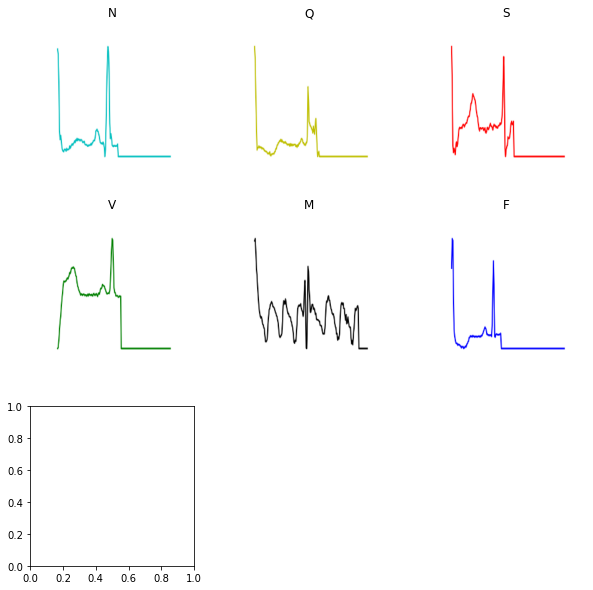

In [13]:
data=tf.keras.utils.image_dataset_from_directory("dataset",labels='inferred',class_names=["F","M","N","Q","S","V"])

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(data.class_names[labels[i]])
    plt.axis("off")


### Part 2 :  creating the model ###

### Part 3 : training and testing ###